In [6]:
import math
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import Program, H, X
from qat.lang.AQASM.arithmetic import modular_exp
import qat.lang.AQASM.qftarith as qftarith
import qat.lang.AQASM.classarith as classarith
import random

def is_prime(N):
    for i in range(2, N-1):
        if N % i == 0:
            return False
    else:
        return True
    
def compute_prime_power(N):
    """
    O(L^3) algo to check if N is the power of a prime number
    
    Returns:
        int: u s.t u**b == N if exists, else -1
    """
    L = math.ceil(math.log2(N))
    for b in range(2, L):
        u1 = math.floor(N**(1./b))
        u2 = u1 + 1
        if u1**b == N: return u1
        if u2**b == N: return u2
    return -1

assert(compute_prime_power(13**4) == 169)
assert(compute_prime_power(11*3) == -1)



def make_shor_circ(a, N, n_phase_bits):
    """
    Args:
        a (integer): the integer a
        N (integer): the integer N
        n_phase_bits (int): the number of phase bits
        qpu (QPU): a qpu
    
    Returns:
        Circuit: the circuit corresponding to Shor's algorithm
    """
    L = math.ceil(math.log2(N))
    
    prog = Program()
    phase_reg = prog.qalloc(n_phase_bits)
    data_reg = prog.qalloc(L)
    
    for qb in range(n_phase_bits):
        H(phase_reg[qb])
        
    for qb in range(L):
        X(data_reg[qb])
        
    prog.apply(modular_exp(n_phase_bits, L, a, N), phase_reg, data_reg)
    prog.apply(IQFT(n_phase_bits), phase_reg)
    
    #return prog.to_circ(link=[qftarith])
    return prog.to_circ(link=[classarith])

from qat.core.util import statistics
def perform_shor_qpe(a, N, n_phase_bits, qpu, nbshots=100, verbose=False):
    """
    Args:
        a (integer): the integer a
        N (integer): the integer N
        n_phase_bits (int): the number of phase bits
        qpu (QPU): a qpu
        
    Returns:
        list<int>: the nbshots-long list of integers (betw 0 and 2**n_phase_bits - 1)
    """
    circ = make_shor_circ(a, N, n_phase_bits)
    
    if verbose:
        print("Shor circ stats:", statistics(circ))
        print("nbshots = ", nbshots)
    
    job = circ.to_job(nbshots=nbshots,
                      qubits=list(range(n_phase_bits)))
    
    res = qpu.submit(job)
    int_list = [(sample.probability, sample.state.int, sample.err) for sample in res]
    
    if verbose:
        for prob, state_int, err in int_list:
            print("%s : %s +/- %s"%(state_int, prob, err))
            
    int_list_sorted = [state_int for _, state_int, _ in reversed(sorted(int_list)) if state_int > 0]
    
    if len(int_list_sorted) > 0:
        return int_list_sorted
        
    raise Exception("Did not get sample different from zero. Should increase nbshots")
        
def compute_order(a, N, n_phase_bits, verbose=False):
    """
    Find lowest positive integer r such that a^r == 1 mod. N
    
    Args:
        a (integer): the integer a
        N (integer): the integer N
    """
    int_list = perform_shor_qpe(a, N, n_phase_bits, qpu, verbose=verbose)
    if verbose:
        print("QPE yields y = %s"%y)
    for state_int in int_list:
        if verbose:
            print("Trying to find r for state_int = %s"%state_int)
        try:
            #_, r = perform_continued_fraction_expansion(y, N)
            _, r = convergent(state_int, 2**n_phase_bits, b=N)
            if a**r % N == 1:
                return r
            print("Failed, next...")
        except Exception:
            print("Exception in convergent")
    
    raise Exception("Could not compute order")


import numpy as np
def perform_shor(N, qpu, max_n_trials=100, n_phase_bits=None, verbose=False):
    """
    Args:
        N (integer): the number to be factorized
        qpu (QPU): a qpu
    """
    # trivial cases
    if N%2 == 0: return 2
    if is_prime(N): return N
    u = compute_prime_power(N)
    if u != -1: return u
    
    already_tested = []
    n_it = 0
    while n_it < max_n_trials:
        n_it += 1
        a = random.randint(3, N)
        #a = 11
        if a in already_tested:
            continue
        else:
            already_tested.append(a)
        if verbose:
            print("Trying with a = %s"%a)
        g = math.gcd(a, N)
        if g != 1:
            return g
        # else: a and N are coprime
        r = compute_order(a, N, n_phase_bits, verbose)
        if verbose:
            print("Found order r = %s"%r)
            
        if r % 2 == 1:
            if verbose:
                print("r odd, trying new a...")
            continue
        if (a**(r//2)) % N == -1:
            if verbose:
                print("(a^(r//2)) % N == -1, trying new a...")
            continue
        g1 = math.gcd(a**(r//2)+1, N)
        g2 = math.gcd(a**(r//2)-1, N)
        if N % g1 == 0 and g1 != N: return g1
        if N % g2 == 0 and g2 != N: return g2
        
        
    raise Exception("did not find factorization, try increasing max_n_trials!")
    

In [2]:
def continued_fraction_expansion(n: int, b: int, q: int) -> int:
    """
    Extracts the period knowing the final state measured on the quantum computer at the end of Shor's algorithm
    execution. This extraction is performed using continued fraction expansion.
    :param n: (int) the integer we want to factorize
    :param b: (int) the measured state expressed in decimal base
    :param q: (int) the length of the first register use in Shor's algorithm
    :return: (int) the period researched in Shor's algorithm
    """

    # Initialize the float whose fractional expansion is looking for
    x = b/q

    # Compute the two first value of the expansion
    a_seq = [int(np.trunc(x))]
    if x == a_seq[-1]:
        raise ValueError('fail to find the period')
    x = 1 / (x - a_seq[-1])

    a_seq.append(int(np.trunc(x)))
    if x == a_seq[-1]:
        raise ValueError('fail to find the period')
    x = 1 / (x - a_seq[-1])

    # Init p and q sequences
    p_seq = [a_seq[0], a_seq[0] * a_seq[1] + 1]
    q_seq = [1, a_seq[1]]

    # Continue the expansion until the period i
    while q_seq[-1] < n:
        a_seq.append(int(np.trunc(x)))
        p_seq.append(a_seq[-1] * p_seq[-1] + p_seq[-2])
        q_seq.append(a_seq[-1] * q_seq[-1] + q_seq[-2])

        # If |b/q - p_n/q_n| < 1/q with q_n < n then r = q_n so the function returns the period
        if np.abs(b/q - p_seq[-1] / q_seq[-1]) < 1 / (2 * q):
            return q_seq[-1]

        if x == a_seq[-1]:
            raise ValueError('fail to find the period')
        x = 1/(x - a_seq[-1])

    # There is a non-zero probability that the algorithm fails to find the period because the measured state does no
    # match, in this case an exception is raised to indicate that the research must be continued
    raise ValueError('fail to find the period')


    
def perform_continued_fraction_expansion(y, N):
    """
    Computes integers d, r' such that r' < N and |y/N - d/r'| < 2**(n_phase_bits + 1)  
    
    Args:
        y (float): a number 
        N (integer): an integer
        
    Returns:
        integer: r'
    
    """
    a = math.floor(y) # 0
    eps = y - a #0.5
    p_prev = a # 0
    a = math.floor(1/eps) # 2
    eps = 1/eps - a #0
    p = a * p_prev + 1
    q_prev = 1
    q = a
    print(p, q, p_prev, q_prev, eps)
    while True:
        a = math.floor(1/eps)
        eps = 1/eps - a
        p_temp = p
        q_temp = q
        p = a * p + p_prev
        q = a * q + q_prev
        p_prev = p_temp
        q_prev = q_temp
        
        if q_prev < N and q >= N: return int(p_prev), int(q_prev)
        
        
########################################################
# This function directly returns the first convergent of
# the continous fraction expansion of a ratio p / q
# which has a numerator exceeding b or the m-th convergent,
# whichever condition occurs first
########################################################

def convergent(p, q, b = None):
    X = []
    n = 0
    p_n_minus2 = 0
    p_n_minus1 = 1
    q_n_minus1 = 0
    q_n_minus2 = 1
    while (q != 0):
        #
        # Compute a_n
        #
        a_n = p // q
        r = p % q
        p = q
        q = r
        n = n + 1
        #
        # Compute p_n and q_n
        #
        p_n = a_n * p_n_minus1 + p_n_minus2
        q_n = a_n * q_n_minus1 + q_n_minus2
        #
        # If we have reached the precision or
        # the desired number of steps return result
        #
        if q_n > b:
            return p_n_minus1, q_n_minus1
        #
        # Shift variables
        #
        q_n_minus2 = q_n_minus1
        q_n_minus1 = q_n
        p_n_minus2 = p_n_minus1
        p_n_minus1 = p_n
    return p_n, q_n

In [3]:
%%time
n_phase_bits = 9

res_int_list = [171, 256, 341, 427]
N = 21
a = 11

q_sol = 6

for res_int in res_int_list:
    print("==== res_int = %s ====="%res_int)
    y = res_int / 2**n_phase_bits
    print("y=", y)
    try:
        p, q = perform_continued_fraction_expansion(y, N)
        print("p, q = %s, %s (gcd = %s)"%(p, q, math.gcd(p, q)))
        #assert(q==q_sol)
        assert(a**q %N == 1)
    except Exception as exc:
        print("FAIL (1):", exc)
    """
    try:
        q = continued_fraction_expansion(N, res_int, n_phase_bits)
        print("q=", q)
        assert(q==q_sol)
    except Exception as exc:
        print("FAIL (2):", exc)
    """
    try:
        p, q = convergent(res_int, 2**n_phase_bits, b=N)
        print("p, q = %s, %s (gcd = %s)"%(p, q, math.gcd(p, q)))
        #assert(q==q_sol)
        assert(a**q %N == 1)
    except Exception as exc:
        print("FAIL (3):", exc)

==== res_int = 171 =====
y= 0.333984375
1 2 0 1 0.9941520467836256
p, q = 1, 3 (gcd = 1)
FAIL (1): 
p, q = 1, 3 (gcd = 1)
FAIL (3): 
==== res_int = 256 =====
y= 0.5
1 2 0 1 0.0
FAIL (1): float division by zero
p, q = 1, 2 (gcd = 1)
FAIL (3): 
==== res_int = 341 =====
y= 0.666015625
1 1 0 1 0.501466275659824
p, q = 2, 3 (gcd = 1)
FAIL (1): 
p, q = 2, 3 (gcd = 1)
FAIL (3): 
==== res_int = 427 =====
y= 0.833984375
1 1 0 1 0.1990632318501171
p, q = 5, 6 (gcd = 1)
p, q = 5, 6 (gcd = 1)
CPU times: user 964 µs, sys: 978 µs, total: 1.94 ms
Wall time: 1.29 ms


In [10]:
%%time
from qat.qpus import get_default_qpu
from qat.qpus import LinAlg

N = 15
#n_phase_bits =

qpu = LinAlg()

try:
    res = perform_shor(N, qpu, max_n_trials=100, n_phase_bits=n_phase_bits, verbose=True)
    print("a factor of N = %s is %s"%(N, res))
except Exception as exc:
    print(exc)

Trying with a = 11
Shor circ stats: {'nbqbits': 25, 'size': 15, 'gates': {'custom gate': 0, 'H': 18, 'X': 1653, 'CNOT': 1648, 'CCNOT': 2736, 'C-C-CNOT': 1512, 'C-C-X': 688, 'C-C-C-CNOT': 360, 'C-C-C-X': 288, 'C-SWAP': 36, 'C-PH': 36}, 'measure': 0, 'reset': 0, 'logic': 0, 'break': 0, 'remap': 0, 'gate_size': 8975}
nbshots =  100
0 : 0.39 +/- 0.04902071300001973
37 : 0.01 +/- 0.01
83 : 0.01 +/- 0.01
107 : 0.01 +/- 0.01
117 : 0.01 +/- 0.01
149 : 0.02 +/- 0.01407052941362897
171 : 0.02 +/- 0.01407052941362897
173 : 0.01 +/- 0.01
197 : 0.01 +/- 0.01
211 : 0.01 +/- 0.01
256 : 0.37 +/- 0.048523658709390974
297 : 0.01 +/- 0.01
299 : 0.01 +/- 0.01
331 : 0.01 +/- 0.01
339 : 0.01 +/- 0.01
341 : 0.03 +/- 0.01714466079977653
363 : 0.01 +/- 0.01
411 : 0.01 +/- 0.01
419 : 0.01 +/- 0.01
421 : 0.01 +/- 0.01
437 : 0.01 +/- 0.01
475 : 0.01 +/- 0.01
QPE yields y = 0.833984375
Trying to find r for state_int = 256
Found order r = 2
a factor of N = 15 is 3
CPU times: user 9min 44s, sys: 3.21 s, total: 9min 

In [43]:
print(res)

3


In [4]:
%%time
a = 11
N = 21
n_phase_bits = 9
circ = make_shor_circ(a, N, n_phase_bits)
    
job = circ.to_job(nbshots=0,
                  qubits=list(range(n_phase_bits)))
qpu = LinAlg()
res2 = qpu.submit(job)

CPU times: user 1h 27min 10s, sys: 10.2 s, total: 1h 27min 20s
Wall time: 11min 5s


0 0.09819030761718722
1 0.0025546728573733707
2 0.002537667164718958
4 0.002574871025086147
8 0.0025128922126507677
16 0.002690010062718815
32 0.002531107782843627
43 0.004397810052549361
53 0.0020957356783069202
64 0.004028320312499989
75 0.0026598355720260087
77 0.0025155788221191597
80 0.003071872009094551
83 0.0053069676826575886
84 0.007187968295922646
85 0.06664973877688661
86 0.016967352963268404
87 0.00452992753854302
88 0.004075322136010217
91 0.002614187770629499
96 0.0025958453421563595
101 0.002016939069845903
107 0.0033259177051077164
128 0.0065460205078124835
149 0.0033259177051077156
155 0.0020169390698459026
160 0.002595845342156359
165 0.0026141877706294986
168 0.004075322136010217
169 0.004529927538543014
170 0.016967352963268397
171 0.06664973877688661
172 0.007187968295922648
173 0.005306967682657593
176 0.0030718720090945513
179 0.0025155788221191593
181 0.002659835572026011
192 0.004028320312499988
203 0.0020957356783069194
213 0.00439781005254936
224 0.0025311077

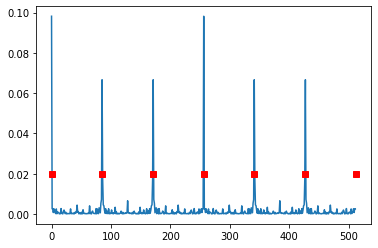

In [21]:
psi_out = np.zeros(2**n_phase_bits)
for sample in res2:
    psi_out[sample.state.int] = sample.probability
    if sample.probability > 0.002:
        print(sample.state.int, sample.probability)
    
import matplotlib.pyplot as plt
plt.plot(psi_out)
r = 6 # for a = 11, N = 21
expect = [2**n_phase_bits * k / r for k in range(7)]
plt.plot(expect, [0.02 for _ in expect], 'sr')

In [14]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()

N=15
n_phase_bits = 2*4

res = perform_shor(N, qpu, max_n_trials=100, n_phase_bits=n_phase_bits, verbose=True)

Trying with a = 11
Shor circ stats: {'size': 10, 'gates': {'custom gate': 0, 'H': 16, 'X': 1473, 'CNOT': 1472, 'CCNOT': 2432, 'C-C-CNOT': 1344, 'C-C-X': 616, 'C-C-C-CNOT': 320, 'C-C-C-X': 256, 'C-SWAP': 32, 'C-PH': 28}, 'measure': 0, 'reset': 0, 'logic': 0, 'break': 0, 'remap': 0, 'gate_size': 7989}
QPE yields y = 0.0


ZeroDivisionError: float division by zero